In [1]:
import cv2 , os 
data_path = 'Face_Mask/Train'
categories = os.listdir(data_path)
labels = [i for i in range(len(categories))]

label_dict = dict(zip(categories , labels))

print(label_dict)
print(categories)
print(labels)


{'without_mask': 0, 'with_mask': 1}
['without_mask', 'with_mask']
[0, 1]


In [2]:
img_size = 100
data = []
target = []

for category in categories:
    folder_path  = os.path.join(data_path , category)
    img_names = os.listdir(folder_path)
    
    for img_name in img_names:
        img_path = os.path.join(folder_path , img_name)
        img = cv2.imread(img_path)
        try:
            gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

            resized = cv2.resize(gray , (img_size, img_size))

            data.append(resized)

            target.append(label_dict[category])

        except Exception as e:
            print('Exception: ', e)

        

In [3]:
import numpy as np

data = np.array(data) / 255.0

data = np.reshape(data , (data.shape[0], img_size, img_size, 1 ))

target = np.array(target)

from keras.utils import np_utils
new_target = np_utils.to_categorical(target)

np.save('data', data)
np.save('target', new_target)


In [4]:
import numpy as np 

data = np.load('data.npy')
target = np.load('target.npy')


In [6]:
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout
from keras.layers import Conv2D,MaxPooling2D
from keras.callbacks import ModelCheckpoint

model = Sequential()
model.add(Conv2D(200,(3 , 3), input_shape = data.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2 , 2)))


model.add(Conv2D(100 , (3 , 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2 , 2)))


model.add(Flatten())

model.add(Dropout(0.5))


model.add(Dense(50 , activation='relu'))

model.add(Dense(2 , activation='softmax'))

model.compile(loss='categorical_crossentropy' , optimizer='adam' , metrics=['accuracy'])



In [7]:
from sklearn.model_selection import train_test_split

train_data , test_data , train_target , test_target = train_test_split(data , target , test_size = 0.1)

In [8]:
checkpoint = ModelCheckpoint('model-{epoch:03d}.model' , monitor = 'val-loss' , verbose= 0 , save_best_only= True ,mode='auto')
            
history = model.fit(train_data , train_target , epochs= 20 , callbacks= [checkpoint] , validation_split= 0.2)
model.save("Face_Mask/Models/{NAME}.model")

Epoch 1/20
30/30 [==============================] - 36s 1s/step - loss: 0.7019 - accuracy: 0.4925 - val_loss: 0.6147 - val_accuracy: 0.6245
Epoch 2/20
30/30 [==============================] - 34s 1s/step - loss: 0.5834 - accuracy: 0.7142 - val_loss: 0.4209 - val_accuracy: 0.8143
Epoch 3/20
30/30 [==============================] - 33s 1s/step - loss: 0.3631 - accuracy: 0.8532 - val_loss: 0.3286 - val_accuracy: 0.8776
Epoch 4/20
30/30 [==============================] - 33s 1s/step - loss: 0.2785 - accuracy: 0.8940 - val_loss: 0.2486 - val_accuracy: 0.8987
Epoch 5/20
30/30 [==============================] - 38s 1s/step - loss: 0.1886 - accuracy: 0.9341 - val_loss: 0.2835 - val_accuracy: 0.8987
Epoch 6/20
30/30 [==============================] - 38s 1s/step - loss: 0.1850 - accuracy: 0.9306 - val_loss: 0.3827 - val_accuracy: 0.8481
Epoch 7/20
30/30 [==============================] - 37s 1s/step - loss: 0.1945 - accuracy: 0.9177 - val_loss: 0.2739 - val_accuracy: 0.9072
Epoch 8/20
30/30 [==

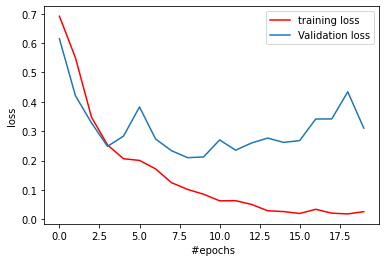

In [9]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'] , 'r' , label= 'training loss')
plt.plot(history.history['val_loss'] , label = 'Validation loss')

plt.xlabel(' #epochs')
plt.ylabel('loss')
plt.legend()
plt.show()



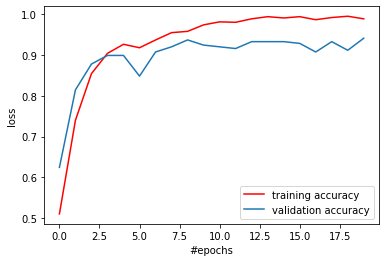

In [10]:
plt.plot(history.history['accuracy'] , 'r' , label = 'training accuracy')
plt.plot(history.history['val_accuracy']  ,label = 'validation accuracy')
plt.xlabel('#epochs')
plt.ylabel('loss')
plt.legend()
plt.show()


In [11]:
print(model.evaluate(test_data,test_target))


5/5 [==============================] - 1s 192ms/step - loss: 0.2241 - accuracy: 0.9470
[0.2241351157426834, 0.9469696879386902]


In [14]:

from keras.models import load_model
import cv2
import numpy as np
import os

os.environ['KMP_DUPlICATE_LIB_OK'] = 'True'



model = load_model("Face_Mask/Models/{NAME}.model")

# face_clsfr=cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

source=cv2.VideoCapture(0)

labels_dict={1:'MASK',0:'NO MASK'}
color_dict={1:(0,255,0),0:(0,0,255)}
while(True):

    ret,img=source.read()
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    faces = face_cascade.detectMultiScale(gray)
    # faces=face_clsfr.detectMultiScale(gray,1.3,5)  

    for (x,y,w,h) in faces:
    
        face_img=gray[y:y+w,x:x+w]
        resized=cv2.resize(face_img,(100,100))
        normalized=resized/255.0
        reshaped=np.reshape(normalized,(1,100,100,1))
        result=model.predict(reshaped)

        label=np.argmax(result,axis=1)[0]
      
        cv2.rectangle(img,(x,y),(x+w,y+h),color_dict[label],2)
        cv2.rectangle(img,(x,y-40),(x+w,y),color_dict[label],-1)
        cv2.putText(img, labels_dict[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
        
        
    cv2.imshow('LIVE',img)
    key=cv2.waitKey(1)
    
    if(key==27):
        break
        
cv2.destroyAllWindows()
source.release()


# from keras.models import load_model
# import cv2
# import numpy as np
# import os

# os.environ['KMP_DUPlICATE_LIB_OK'] = 'True'

# model = load_model("/Face_Mask/Models/{NAME}.model")

# face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))


# source = cv2.VideoCapture(0)


# labels_dict = {0 : 'Without_Mask' , 1: 'With_Mask'}
# color_dict = {0: (0,0,255) , 1:(0,255,0)}

# while(True):
    
#     ret,img = source.read()
#     gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#     faces = face_cascade.detectMultiScale(gray)

#     # faces = face_cascade.detectMultiScale(gray,1.3,5)

#     for x, y, w , h in faces:
#         face_img = gray[y:y+w,x:x+w]
#         resized = cv2.resize(face_img,(100 ,100))
#         normalized = resized / 255.0
#         reshaped = np.reshape(normalized,(1,100,100,1))
#         result = model.predict(reshaped)

#         label = np.argmax(result,axis=1)[0]


#         cv2.rectangle(img , (x,y) , (x+w,y+h) , color_dict[label], 2)
#         cv2.rectangle(img , (x,y-40) , (x+w ,y) , color_dict[label] , -1)
#         cv2.putText(img , labels_dict[label] , (x, y-10) ,  cv2.FONT_HERSHEY_SIMPLEX , 0.8,(255,255,255) , 2)


#     cv2.imshow('LIVE' ,img)
#     if cv2.waitkey(1) & 0xFF == ord('q'):
#         break


# source.release()
# cv2.distroyAllWindows()
